In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import numpy as np
import jax.numpy as jnp
import jax
from orbax.checkpoint import PyTreeCheckpointer
from dataclasses import dataclass
import tyro

from genie import Genie
from data.dataloader import get_dataloader

In [2]:
# @dataclass
# class Args:
    # Experiment
num_steps: int = 200_000
seed: int = 0
seq_len: int = 16
image_channels: int = 3
image_resolution: int = 64
file_path: str = "data/coinrun.npy"
# Optimization
batch_size: int = 36
min_lr: float = 3e-6
max_lr: float = 3e-5
warmup_steps: int = 5000
# Tokenizer
tokenizer_dim: int = 512
latent_patch_dim: int = 32
num_patch_latents: int = 1024
patch_size: int = 4
tokenizer_num_blocks: int = 8
tokenizer_num_heads: int = 8
tokenizer_checkpoint: str = ""
# LAM
lam_dim: int = 512
latent_action_dim: int = 32
num_latent_actions: int = 6
lam_patch_size: int = 16
lam_num_blocks: int = 8
lam_num_heads: int = 8
lam_checkpoint: str = ""
# Dynamics
dyna_dim: int = 512
dyna_num_blocks: int = 12
dyna_num_heads: int = 8
dropout: float = 0.0
mask_limit: float = 0.5
# Logging
log: bool = False
entity: str = ""
project: str = ""
log_interval: int = 5
log_image_interval: int = 250
ckpt_dir: str = ""
log_checkpoint_interval: int = 25000
log_gradients: bool = False

In [3]:
# args = tyro.cli(Args)
rng = jax.random.PRNGKey(seed)

In [4]:
genie = Genie(
    # Tokenizer
    in_dim=image_channels,
    tokenizer_dim=tokenizer_dim,
    latent_patch_dim=latent_patch_dim,
    num_patch_latents=num_patch_latents,
    patch_size=patch_size,
    tokenizer_num_blocks=tokenizer_num_blocks,
    tokenizer_num_heads=tokenizer_num_heads,
    # LAM
    lam_dim=lam_dim,
    latent_action_dim=latent_action_dim,
    num_latent_actions=num_latent_actions,
    lam_patch_size=lam_patch_size,
    lam_num_blocks=lam_num_blocks,
    lam_num_heads=lam_num_heads,
    # Dynamics
    dyna_dim=dyna_dim,
    dyna_num_blocks=dyna_num_blocks,
    dyna_num_heads=dyna_num_heads,
    dropout=dropout,
    mask_limit=mask_limit,
)

In [5]:
rng, _rng = jax.random.split(rng)
image_shape = (image_resolution, image_resolution, image_channels)
dummy_inputs = dict(
    videos=jnp.zeros((batch_size, seq_len, *image_shape), dtype=jnp.float32),
    mask_rng=_rng,
)
rng, _rng = jax.random.split(rng)
init_params = genie.init(_rng, dummy_inputs)

In [ ]:
genie_params = '/homes/80/timonw/checkpoints/genie_1721738387_200000'
tokenizer_params = '/homes/80/timonw/checkpoints/tokenizer_1721412317_290000'
params = PyTreeCheckpointer().restore(genie_params)


/home/duser/.local/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1442: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [ ]:
# print(params['model']['params']['params']['dynamics']['dynamics']['STBlock_3'][''].keys())
init_params['params'].update(params['model']['params']['params'])

In [ ]:
dataloader = get_dataloader(file_path, seq_len, batch_size)

In [ ]:
max_steps = 1
curr = 0
num_samples = 1
for videos in dataloader:
    rng, _rng = jax.random.split(rng)
    actions = jax.random.randint(_rng, shape=(batch_size, 15), minval=0, maxval=6)
    videos = jnp.array(videos, dtype=jnp.float32)[:, :15] / 255.0
    for i in range(num_samples):
        rng, _rng = jax.random.split(rng)
        print(videos.shape)
        inp = dict(
            videos=videos,
            rng=_rng,
            latent_actions=actions
        )
        
        generated_frames = genie.sample(init_params, inp, _rng)
        videos = jnp.concatenate([videos[:, 1:], generated_frames], axis=1)
        action = jax.random.randint(_rng, shape=(batch_size, 1), minval=0, maxval=6)
        actions = jnp.concatenate([actions[:, 1:], action], axis=1)
    curr += 1
    if curr == max_steps:
        break

/homes/80/timonw/flairox_jafar/data/dataloader.py:35: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(sequence).clone()


(36, 15, 64, 64, 3)


In [ ]:
generated_frames.shape

(36, 16, 64, 64, 3)

In [ ]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

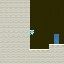

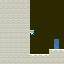

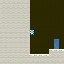

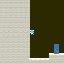

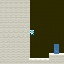

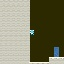

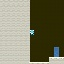

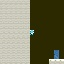

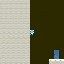

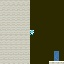

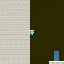

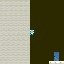

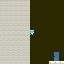

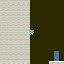

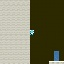

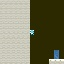

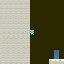

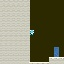

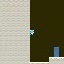

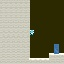

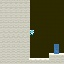

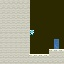

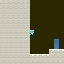

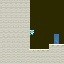

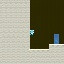

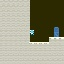

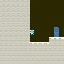

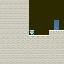

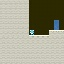

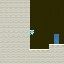

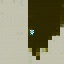

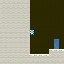

In [ ]:
# imshow(np.asarray(sampled_images[0, 0]*255.0))
for i in range(generated_frames.shape[1]):
    imshow(np.asarray(generated_frames[0, i]*255.0))
    imshow(np.asarray(videos[0, i]*255.0))
# imshow(np.asarray(videos[2, ]*255.0))

In [ ]:
print(generated_frames[0,])

[[[[0.733251   0.7981451  0.8018075 ]
   [0.73127604 0.7965537  0.8003893 ]
   [0.6939343  0.75190157 0.7523649 ]
   ...
   [0.00168101 0.15667439 0.17141302]
   [0.00151207 0.15468474 0.17115042]
   [0.00165783 0.15452313 0.17112982]]

  [[0.7326673  0.79560626 0.79957634]
   [0.733003   0.7959938  0.79989177]
   [0.76858616 0.8176346  0.82082886]
   ...
   [0.0015366  0.15634273 0.17386569]
   [0.00144092 0.15462722 0.17263101]
   [0.00136558 0.1555184  0.17129004]]

  [[0.6940729  0.75293773 0.7557304 ]
   [0.6949446  0.75664103 0.7573769 ]
   [0.6930435  0.75341964 0.75663966]
   ...
   [0.00147447 0.15765785 0.17292674]
   [0.00109022 0.15468632 0.17132881]
   [0.0014722  0.15600327 0.17277189]]

  ...

  [[0.6897461  0.7496823  0.75324225]
   [0.77367723 0.8204924  0.8238434 ]
   [0.6885028  0.75165474 0.7554853 ]
   ...
   [0.6943596  0.75166947 0.75572026]
   [0.69250923 0.7517265  0.75668424]
   [0.69058496 0.75088686 0.75724083]]

  [[0.69197816 0.7506735  0.75493133]
   [0.6